In [1]:
import pathlib
import warnings
# import json

# from attrs import define, field, evolve
# import polars as pl
import numpy as np
import matplotlib.pyplot as plt

from odbex.post import OdbexData

In [2]:
TEST_DATA = pathlib.Path(r"odbex_analysis_000.npz")
odbex_data = OdbexData(TEST_DATA)

In [3]:
odbex_data.set_region("assembly|ELECTRODE_IFACE", "node")
odbex_data.set_step("Step-1")
odbex_data.set_field("CSHEAR1")
stress, _ = odbex_data.get_field_data("CSHEAR1")
strain, _ = odbex_data.get_field_data("CSLIP1")

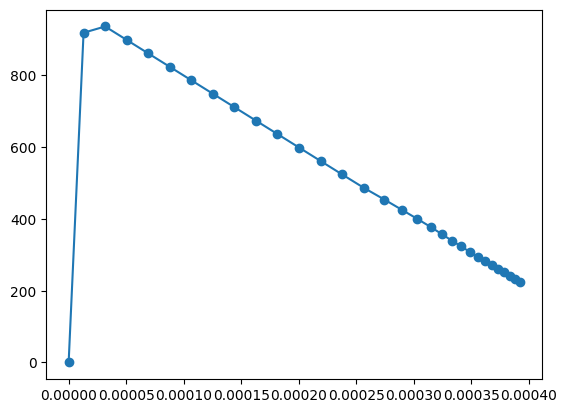

In [8]:
fig, ax = plt.subplots()
ax.plot(strain[0], stress[0], marker='o')

In [4]:
TEST_DATA = pathlib.Path(r'G:\My Drive\postdoc\rsoc\unit_tests\jobs_model_2_quad\unit_test_axisym_cohesive_surf_1\odbex_unit_test_axisym_cohesive_surf_1.npz')

In [5]:
sd = simdata.SimulationData.from_extracted(TEST_DATA)
model_data = sd.get_region_data('cure-step', 'SET-ALLELEMENTS')
stress = model_data.volume_average_field('S')
strain = model_data.volume_average_field('E')

NameError: name 'simdata' is not defined

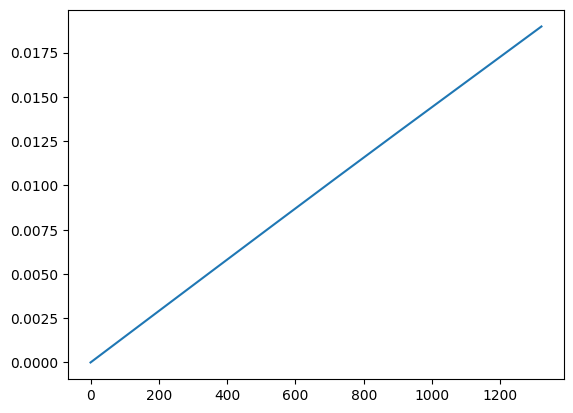

In [ ]:
fig, ax = plt.subplots()
ax.plot(model_data.field_data['E'].increments.values(), strain.data[:, 1])